# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from tqdm import tqdm
import requests
import rioxarray as rxr
import geopandas as gpd
import pandas as pd
import datetime

from shapely.geometry import Point

import folium
from folium.plugins import *

import concurrent.futures
import multiprocessing as mp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import sys

sys.path.insert(0, "../../src")
from run_mp import *
from gee_data_wrangling import *
from gee_data_download import *

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_doiqkQG3NJ1t8IS?source=API


In [2]:
import ee

# ee.Authenticate()
ee.Initialize()

# Visualise the site coordinates

In [6]:
# Read CSV file with x and y coordinates
csv_path = "sites_years.csv"
df = pd.read_csv(csv_path)
df = get_nfi_coordinates_site_year(with_idp=True)

# Create a GeoDataFrame with Point geometries
geometry = [Point(xy) for xy in zip(df["x"], df["y"])]
geo_df = gpd.GeoDataFrame(
    df, geometry=geometry, crs="EPSG:4326"
)  # Assuming WGS84 (EPSG:4326)

geo_df.head(10)

# Save the GeoDataFrame to a shapefile
# output_shapefile = 'output.shp'
# geo_df.to_file(output_shapefile)

first_year  SiteID         x          y       idp  \
0        2011       1 -2.842824  48.337505  632691.0   
1        2012       2  3.349757  46.198025  702597.0   
2        2012       3  3.361577  46.827747  706240.0   
3        2012       4  0.402182  48.201563  708321.0   
4        2012       5  6.461081  43.281648  708369.0   
5        2012       6  3.562693  46.447864  709385.0   
6        2012       7 -1.081578  43.288368  710767.0   
7        2012       8  2.635621  48.289030  711712.0   
8        2012       9  4.660504  44.414816  711896.0   
9        2012      10  4.249590  45.250478  712948.0   

                    geometry  
0  POINT (-2.84282 48.33751)  
1   POINT (3.34976 46.19803)  
2   POINT (3.36158 46.82775)  
3   POINT (0.40218 48.20156)  
4   POINT (6.46108 43.28165)  
5   POINT (3.56269 46.44786)  
6  POINT (-1.08158 43.28837)  
7   POINT (2.63562 48.28903)  
8   POINT (4.66050 44.41482)  
9   POINT (4.24959 45.25048)

In [12]:
test_v = ["idp", "SiteID"]

" | ".join([f"{i+1} : {elem}" for i, elem in enumerate(test_v)])

'1 : idp | 2 : SiteID'

In [4]:
def create_map(geo_df, add_labels = []):
    # Create a folium map centered at the mean coordinates
    map_center = [geo_df["y"].mean(), geo_df["x"].mean()]
    my_map = folium.Map(location=map_center, zoom_start=6, control_scale=True)

    # Add World Imagery TileLayer
    folium.TileLayer(
        "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        name="World Imagery",
        attr="Esri",
    ).add_to(my_map)

    # Add World Topo Map TileLayer
    folium.TileLayer(
        "https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}",
        name="World Topo",
        attr="Esri",
    ).add_to(my_map)

    # Create a MarkerCluster layer for the points
    marker_cluster = MarkerCluster().add_to(my_map)

    # Add points to the MarkerCluster layer
    for _, row in geo_df.iterrows():
        
        if len(add_labels > 0):
            my_popup = " | ".join(
                [f"{elem} : {row[elem]}" for i, elem in enumerate(test_v)]
                )

        folium.Marker(
            location=[row["y"], row["x"]],
            popup=my_popup,
            icon=None,  # You can customize the icon if needed
        ).add_to(marker_cluster)

    # Add a MiniMap for an overview
    # minimap = MiniMap(toggle_display=True).add_to(my_map)

    # Add a Draw control for user interaction
    draw_control = Draw().add_to(my_map)

    # Add a Measure control for distance measurement
    measure_control = MeasureControl(primary_length_unit="kilometers").add_to(my_map)

    # Add layer control with collapsed legend
    folium.LayerControl(collapsed=True).add_to(my_map)

    # Display the map
    return my_map

In [5]:
create_map(geo_df)

KeyError: 'id'

# Cross-check with Land Use Map

## Input Settings

In [164]:
which_one    = "dw"  # "copernicus" or "esa", or "dw"
n_subregions = 30  # Default: 4

## Functions

In [145]:
def div_subregion(box, num_rows, num_cols):
    """Divide a region into subregions.

    Args:
        box: (list) [xmin, ymin, xmax, ymax]
        num_rows: (int) number of rows
        num_cols: (int) number of columns

    Returns:
        (list) list of subregions
    """
    xmin, ymin, xmax, ymax = box
    xstep = (xmax - xmin) / num_cols
    ystep = (ymax - ymin) / num_rows
    subregions = []
    for i in range(num_rows):
        for j in range(num_cols):
            subregions.append(
                [
                    xmin + xstep * j,
                    ymin + ystep * i,
                    xmin + xstep * (j + 1),
                    ymin + ystep * (i + 1),
                ]
            )
    return subregions

## Download Data

In [165]:
# Create subregions
france_bbox = (-5.1424, 42.3837, 9.5619, 51.1242)
subregions = div_subregion(france_bbox, n_subregions, n_subregions)
# print(subregions[0])
subregions = list(map(lambda x: ee.Geometry.BBox(*x), subregions))

# Select dataset
if which_one == "copernicus":
    img = ee.Image("COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019")
    my_bands = ["discrete_classification"]
    my_scale = 100

if which_one == "esa":
    img = ee.Image("ESA/WorldCover/v200/2021")
    my_bands = ["Map"]
    my_scale = 10

# Dynamic World Dataset https://www.nature.com/articles/s41597-022-01307-4
if which_one == "dw":
    img = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1").first()
    my_bands = ["label"]
    my_scale = 10

# print(img.getInfo())
# print(ee.Image("COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019").getInfo())

for index, region in tqdm(enumerate(subregions)):

    # region = ee.Geometry.BBox(-5.1424, 42.3837, 9.5619, 51.1242)
    # img = ee.ImageCollection(my_img)
    url = img.getDownloadUrl(
        {
            "bands": my_bands,
            "region": region,
            "scale": my_scale,
            "format": "GEO_TIFF",
            # "crs": "EPSG:3857",
        }
    )

    response = requests.get(url)
    with open(f"landcover_files/{which_one}_{index}.tif", "wb") as fd:
        fd.write(response.content)

19it [01:08,  3.59s/it]


KeyboardInterrupt: 

In [141]:
# example of plot
tiff_path = "landcover_files/" + which_one + "_1.tif"
rds = rxr.open_rasterio(tiff_path)
rds.plot()

RasterioIOError: 'landcover_files/esa_1.tif' not recognized as a supported file format.

In [142]:
# example of plot
tiff_path = "landcover_files/" + which_one + "_8.tif"
rds = rxr.open_rasterio(tiff_path)
rds.plot()

RasterioIOError: landcover_files/esa_8.tif: No such file or directory

## Detect Closest Pixel

In [143]:
point_values = []
tif_paths = list(
    map(
        lambda x: f"landcover_files/{which_one}_{x}.tif",
        range(0, n_subregions * n_subregions, 1),
    )
)

# extract land cover values from tiff files
for tiff_path in tqdm(tif_paths):
    rds = rxr.open_rasterio(tiff_path)
    rds = rds.rio.reproject("EPSG:4326")

    for id, lat, lon in zip(geo_df["id"], geo_df["y"], geo_df["x"]):
        bounds = rds.rio.bounds()

        # Check if the point is within the raster extent
        if bounds[0] <= lon <= bounds[2] and bounds[1] <= lat <= bounds[3]:
            # value = rds.rio.sample(coords=[(lon, lat)])
            value = rds.sel(x=lon, y=lat, method="nearest")
            point_values.append({"id": id, "lat": lat, "lon": lon, "val": value.item()})

  0%|          | 0/900 [00:00<?, ?it/s]

RasterioIOError: 'landcover_files/esa_0.tif' not recognized as a supported file format.

## Clean Band Encoding

In [121]:
point_values = pd.DataFrame(point_values)
point_values = gpd.GeoDataFrame(
    point_values,
    geometry=gpd.points_from_xy(point_values.lon, point_values.lat),
    crs="EPSG:4326",
)
point_values.val.value_counts()

val
114    13046
40      5797
126     4962
111     4186
115     3604
30      1744
125     1622
116     1187
124      879
50       482
20       318
80        62
121       41
90        24
200        8
60         1
Name: count, dtype: int64

In [122]:
if which_one == "copernicus":
    val_map = {
        20: "Shrubs. Woody perennial plants with persistent and woody stems and without any defined main stem being less than 5 m tall. The shrub foliage can be either evergreen or deciduous.",
        30: "Herbaceous vegetation. Plants without persistent stem or shoots above ground and lacking definite firm structure. Tree and shrub cover is less than 10 %.",
        40: "Cultivated and managed vegetation / agriculture. Lands covered with temporary crops followed by harvest and a bare soil period (e.g., single and multiple cropping systems). Note that perennial woody crops will be classified as the appropriate forest or shrub land cover type.",
        50: "Urban / built up. Land covered by buildings and other man-made structures.",
        60: "Bare / sparse vegetation. Lands with exposed soil, sand, or rocks and never has more than 10 % vegetated cover during any time of the year.",
        80: "Permanent water bodies. Lakes, reservoirs, and rivers. Can be either fresh or salt-water bodies.",
        90: "Herbaceous wetland. Lands with a permanent mixture of water and herbaceous or woody vegetation. The vegetation can be present in either salt, brackish, or fresh water.",
        111: "Closed forest, evergreen needle leaf. Tree canopy >70 %, almost all needle leaf trees remain green all year. Canopy is never without green foliage.",
        114: "Open forest, not matching any of the other definitions.",
        115: "Closed forest, mixed.",
        116: "Closed forest, not matching any of the other definitions.",
        121: "Open forest, evergreen needle leaf. Top layer- trees 15-70 % and second layer- mixed of shrubs and grassland, almost all needle leaf trees remain green all year. Canopy is never without green foliage.",
        124: "Open forest, deciduous broad leaf. Top layer- trees 15-70 % and second layer- mixed of shrubs and grassland, consists of seasonal broadleaf tree communities with an annual cycle of leaf-on and leaf-off periods.",
        125: "Open forest, mixed.",
        126: "Open forest, not matching any of the other definitions.",
        200: "Oceans, seas. Can be either fresh or salt-water bodies.",
    }

    val_map_1 = {
        20: "Shrubs",
        30: "Herbaceous",
        40: "Agriculture",
        50: "Urban",
        60: "Bare",
        80: "Water Bodies",
        90: "Wetland",
        111: "Forest",
        114: "Forest",
        115: "Forest",
        116: "Forest",
        121: "Forest",
        124: "Forest",
        125: "Forest",
        126: "Forest",
        200: "Oceans",
    }

if which_one == "esa":
    val_map = {
        10: "Tree cover",
        20: "Shrubland",
        30: "Grassland",
        40: "Cropland",
        50: "Built-up",
        60: "Bare / sparse vegetation",
        70: "Snow and ice",
        80: "Permanent water bodies",
        90: "Herbaceous wetland",
        95: "Mangroves",
        100: "Moss and lichen",
    }
    
    val_map_1 = {
        10: "Forest",
        20: "Shrubs",
        30: "Grass",
        40: "Cropland",
        50: "Built-up",
        60: "Bare / sparse vegetation",
        70: "Snow and ice",
        80: "Permanent water bodies",
        90: "Herbaceous wetland",
        95: "Mangroves",
        100: "Moss and lichen",
    }

if which_one == "dw":
    val_map = {
        0: "water",
        1: "trees",
        2: "grass",
        3: "flooded_vegetation",
        4: "crops",
        5: "shrub_and_scrub",
        6: "built",
        7: "bare",
        8: "snow_and_ice",
    }
    
    val_map = {
        0: "water",
        1: "Forest",
        2: "Grass",
        3: "flooded_vegetation",
        4: "crops",
        5: "Shrubs",
        6: "built",
        7: "bare",
        8: "snow_and_ice",
    }

## Check Pixel Values

In [123]:
point_values["land_type"] = point_values.val.map(val_map_1)
point_values["type_detail"] = point_values.val.map(val_map)
point_values = point_values.sort_values(by=["id"])
point_values.head(10)

id        lat       lon  val                   geometry    land_type  \
19765   1  48.337505 -2.842824  115  POINT (-2.84282 48.33751)       Forest   
12464   2  46.198025  3.349757  114   POINT (3.34976 46.19803)       Forest   
24616   3  46.827747  3.361577   40   POINT (3.36158 46.82775)  Agriculture   
21016   4  48.201563  0.402182  114   POINT (0.40218 48.20156)       Forest   
6641    5  43.281648  6.461081  126   POINT (6.46108 43.28165)       Forest   
12465   6  46.447864  3.562693  114   POINT (3.56269 46.44786)       Forest   
35      7  43.288368 -1.081578  126  POINT (-1.08158 43.28837)       Forest   
24617   8  48.289030  2.635621  115   POINT (2.63562 48.28903)       Forest   
3532    9  44.414816  4.660504  114   POINT (4.66050 44.41482)       Forest   
12466  10  45.250478  4.249590  126   POINT (4.24959 45.25048)       Forest   

                                             type_detail  
19765                              Closed forest, mixed.  
12464  Open forest, not matching any of the other def...  
24616  Cultivated and managed vegetation / agricultur...  
21016  Open forest, not matching any of the other def...  
6641   Open forest, not matching any of the other def...  
12465  Open forest, not matching any of the other def...  
35     Open forest, not matching any of the other def...  
24617                              Closed forest, mixed.  
3532   Open forest, not matching any of the other def...  
12466  Open forest, not matching any of the other def...

<Axes: ylabel='land_type'>

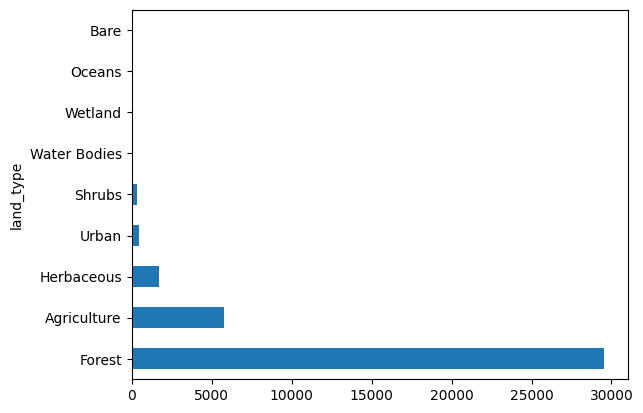

In [124]:
point_values.land_type.value_counts().plot(kind="barh")

## Visualise erroneous sites

In [136]:
okay_types = ["Forest", "Shrubs", "Grass"]

point_subset = point_values.rename(columns={"lat": "y", "lon": "x"}).query(
    "land_type not in @okay_types"
)
create_map(point_subset, add_landtype=True)

## Save output

In [ ]:
point_values.to_csv(f"coords_with_land_cover_{which_one}.csv", index=False)

# Vegetation Index Comparison

## Setup   

In [ ]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, "../../src")

from run_mp import *
from gee_data_wrangling import *

## Load Data

### Modis

In [ ]:
pd.read_feather("./gee-raw-data/modis-vi/site_1.feather").head(10)

date  NDVI   EVI  DetailedQA  SummaryQA SiteID
0 2009-01-01  6726  3367        2193          1      1
1 2009-01-17  7133  3153        2120          0      1
2 2009-02-02  7526  2998        2124          1      1
3 2009-02-18  7188  1984       35225          1      1
4 2009-03-06  7367  3629        2116          0      1
5 2009-03-22  6979  3099        2116          0      1
6 2009-04-07  7122  5424        2062          3      1
7 2009-04-23  7900  3959        2116          0      1
8 2009-05-09  8380  5897        2116          0      1
9 2009-05-25  8731  5429        2116          0      1

In [ ]:
# Load all sites
all_sites = pd.read_csv("../01_download_raw_gee_data/sites_years.csv")
sites_subset = all_sites.copy()
# sites_subset = all_sites.iloc[0:10000, :]
grouped = sites_subset.groupby("id", as_index=False)
df_list = [group for name, group in grouped]

# Load cleaned data
data_modis = run_mp(
    load_and_wrangle_PARALLEL,
    df_list,
    combine_func=pd.concat,
    progress_bar=True,
    num_cores=10,
    subdir="modis-vi",
    verbose=False,
)

data_modis

100%|██████████| 38302/38302 [00:25<00:00, 1531.65it/s]
/Users/pascal/repos/padasch/ifn_analysis/python/01_download_raw_gee_data/../../src/run_mp.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return combine_func(results)


date    NDVI     EVI  DetailedQA  SummaryQA  SiteID  first_year
1   2009-01-17  0.7133  0.3153      2120.0        0.0       1        2011
4   2009-03-06  0.7367  0.3629      2116.0        0.0       1        2011
5   2009-03-22  0.6979  0.3099      2116.0        0.0       1        2011
7   2009-04-23  0.7900  0.3959      2116.0        0.0       1        2011
8   2009-05-09  0.8380  0.5897      2116.0        0.0       1        2011
..         ...     ...     ...         ...        ...     ...         ...
177 2021-09-14  0.8612  0.5709      2116.0        0.0   38302        2016
178 2021-09-30  0.8294  0.4870      2116.0        0.0   38302        2016
179 2021-10-16  0.8280  0.5046      2116.0        0.0   38302        2016
180 2021-11-01  0.6356  0.3082      2120.0        0.0   38302        2016
183 2021-12-19  0.5693  0.1778      2120.0        0.0   38302        2016

[5306170 rows x 7 columns]

In [ ]:
# Take the annual mean
grouped = data_modis.groupby("SiteID", as_index=False)
df_list = [group for name, group in grouped]

data_modis_mean = run_mp(
    take_annual_mean, df_list, combine_func=pd.concat, progress_bar=True, num_cores=10
)
data_modis_mean

100%|██████████| 38298/38298 [00:10<00:00, 3757.53it/s]


SiteID  first_year  mean_ndvi  mean_evi
0        1        2011   0.812527  0.425131
0        2        2012   0.753118  0.462268
0        3        2012   0.465154  0.248397
0        4        2012   0.712838  0.451393
0        5        2012   0.730447  0.374023
..     ...         ...        ...       ...
0    38298        2016   0.818360  0.387256
0    38299        2016   0.706348  0.378374
0    38300        2016   0.699821  0.428448
0    38301        2016   0.761955  0.373124
0    38302        2016   0.749426  0.464655

[38298 rows x 4 columns]

### Sentinel

In [ ]:
# Load all sites
all_sites = pd.read_csv("../01_download_raw_gee_data/sites_years.csv")

sites_subset = all_sites.copy()
# sites_subset = all_sites.iloc[0:10000, :]
grouped = sites_subset.groupby("id", as_index=False)
df_list = [group for name, group in grouped]

data_sentinel = run_mp(
    load_and_wrangle_PARALLEL,
    df_list,
    combine_func=pd.concat,
    progress_bar=True,
    num_cores=10,
    subdir="sentinel",
    verbose=False,
)

data_sentinel

In [ ]:
# Take the annual mean
grouped = data_sentinel.groupby("SiteID", as_index=False)
df_list = [group for name, group in grouped]

data_sentinel_mean = run_mp(
    take_annual_mean, df_list, combine_func=pd.concat, progress_bar=True, num_cores=10
)
data_sentinel_mean

100%|██████████| 35025/35025 [00:10<00:00, 3278.36it/s]


SiteID  first_year  mean_ndvi  mean_evi
0        1        2011   0.652637  0.567754
0        2        2012   0.571417  0.524965
0        3        2012   0.378644  0.271204
0        4        2012   0.609604  0.580500
0        5        2012   0.455987  0.315513
..     ...         ...        ...       ...
0    38290        2016   0.579248  0.600814
0    38293        2016   0.597085  0.591354
0    38294        2016   0.535768  0.447376
0    38295        2016   0.579817  0.556994
0    38300        2016   0.471342  0.449526

[35025 rows x 4 columns]

### Landsat

In [ ]:
# Load all sites
all_sites = pd.read_csv("../01_download_raw_gee_data/sites_years.csv")

sites_subset = all_sites.copy()
# sites_subset = all_sites.iloc[0:10000, :]
grouped = sites_subset.groupby("id", as_index=False)
df_list = [group for name, group in grouped]

data_landsat = run_mp(
    load_and_wrangle_PARALLEL,
    df_list,
    combine_func=pd.concat,
    progress_bar=True,
    num_cores=10,
    subdir="landsat",
    verbose=False,
)

data_landsat

100%|██████████| 38302/38302 [00:31<00:00, 1224.08it/s]


date     SR_B1     SR_B2     SR_B3     SR_B4  \
2   2013-06-06 11:01:24.504000000  0.198680  0.201925  0.226620  0.210863   
3   2013-07-08 11:01:21.773999872  0.199010  0.200083  0.218508  0.203465   
10  2013-11-13 11:01:05.404000000  0.195133  0.201045  0.221093  0.213998   
12  2014-02-01 11:00:25.993999872  0.183225  0.186360  0.193565  0.190403   
23  2014-10-31 10:59:32.637000192  0.187295  0.192988  0.208773  0.202145   
..                            ...       ...       ...       ...       ...   
226 2021-07-02 10:34:56.860000000  0.203740  0.206105  0.228903  0.210313   
227 2021-07-18 10:34:59.104999936  0.200000  0.201595  0.221093  0.204758   
229 2021-09-04 10:35:17.602999808  0.198873  0.202118  0.223293  0.209818   
231 2021-10-22 10:35:29.032000000  0.189798  0.191008  0.212513  0.205693   
232 2021-11-23 10:35:23.805999872  0.200248  0.202723  0.215758  0.221505   

        SR_B5     SR_B6     SR_B7  QA_PIXEL  SiteID  first_year      NDVI  \
2    0.467300  0.310192  0.240040   21824.0       1        2011  0.378136   
3    0.487128  0.303538  0.233660   21824.0       1        2011  0.410752   
10   0.413125  0.279668  0.238308   21824.0       1        2011  0.317526   
12   0.263305  0.206875  0.192548   21824.0       1        2011  0.160682   
23   0.375285  0.256842  0.213338   21824.0       1        2011  0.299846   
..        ...       ...       ...       ...     ...         ...       ...   
226  0.590940  0.342725  0.247768   21824.0   38302        2016  0.475041   
227  0.549937  0.333210  0.240563   21824.0   38302        2016  0.457377   
229  0.512097  0.322018  0.237070   21824.0   38302        2016  0.418720   
231  0.438920  0.282720  0.221725   21824.0   38302        2016  0.361810   
232  0.335272  0.321770  0.260032   21824.0   38302        2016  0.204332   

          EVI  
2    0.526333  
3    0.587391  
10   0.418591  
12   0.180806  
23   0.379444  
..        ...  
226  0.728040  
227  0.681355  
229  0.602093  
231  0.470020  
232  0.248643  

[3154602 rows x 13 columns]

In [ ]:
# Take the annual mean
grouped = data_landsat.groupby("SiteID", as_index=False)
df_list = [group for name, group in grouped]

data_landsat_mean = run_mp(
    take_annual_mean, df_list, combine_func=pd.concat, progress_bar=True, num_cores=10
)
data_landsat_mean

100%|██████████| 38302/38302 [00:11<00:00, 3403.33it/s]


SiteID  first_year  mean_ndvi  mean_evi
0        1        2011   0.314468  0.414094
0        2        2012   0.352088  0.507301
0        3        2012   0.309790  0.429566
0        4        2012   0.344856  0.476677
0        5        2012   0.306249  0.408254
..     ...         ...        ...       ...
0    38298        2016   0.292547  0.371058
0    38299        2016   0.310921  0.436144
0    38300        2016   0.323174  0.445706
0    38301        2016   0.304657  0.414422
0    38302        2016   0.346924  0.492711

[38302 rows x 4 columns]

In [ ]:
# Save all files
data_modis_mean.to_csv("modis_annual_mean.csv")
data_sentinel_mean.to_csv("sentinel_annual_mean.csv")
data_landsat_mean.to_csv("landsat_annual_mean.csv")

## Figures

In [ ]:
def plot_violin(df_input, my_title):
    # Merge with land use data
    data_landuse = (
        pd.read_csv("./point_values.csv", index_col=0)
        .reset_index()
        .rename(columns={"id": "SiteID"})
    )

    data_toplot = pd.merge(df_input, data_landuse, on="SiteID", how="left")
    data_toplot

    # Display violin plots
    sns.set(style="whitegrid")

    fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

    # Create a violin plot for mean_ndvi
    sns.violinplot(x="land_type", y="mean_ndvi", data=data_toplot, ax=axs[0])
    axs[0].set_title("Annual Mean NDVI by Land Type")
    axs[0].set_ylim(0, 1)

    # Create a violin plot for mean_evi
    sns.violinplot(x="land_type", y="mean_evi", data=data_toplot, ax=axs[1])
    axs[1].set_title("Annual Mean EVI by Land Type")
    axs[1].set_ylim(0, 1)

    # Add main title
    fig.suptitle(my_title, fontsize=16)

    plt.tight_layout()

### MODIS

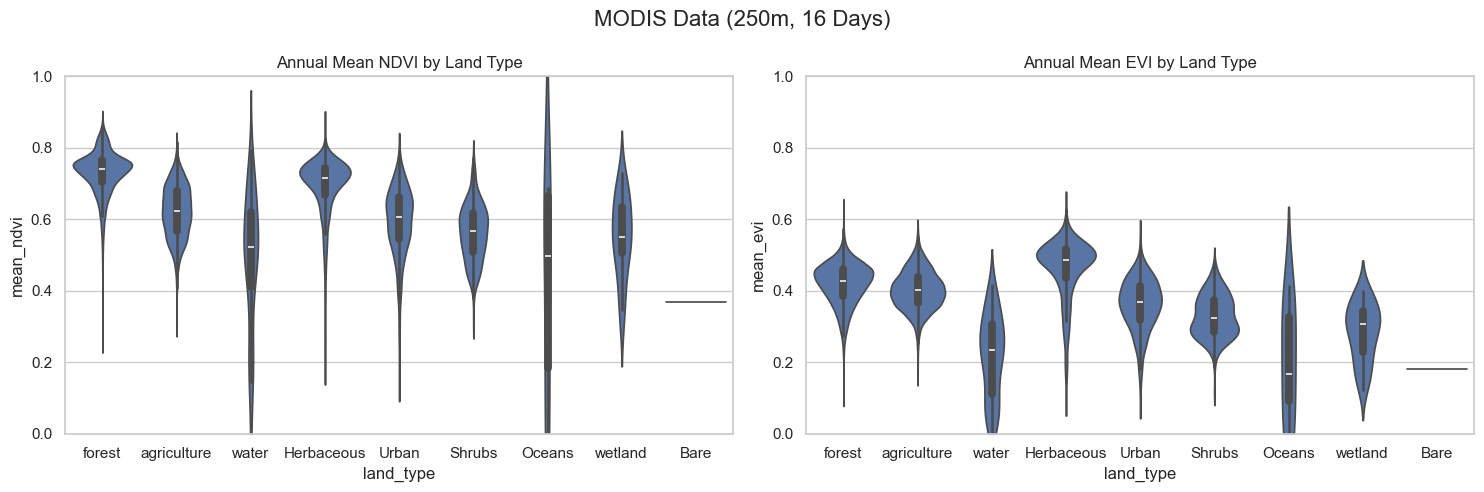

In [ ]:
plot_violin(data_modis_mean, "MODIS Data (250m, 16 Days)")

### Sentinel

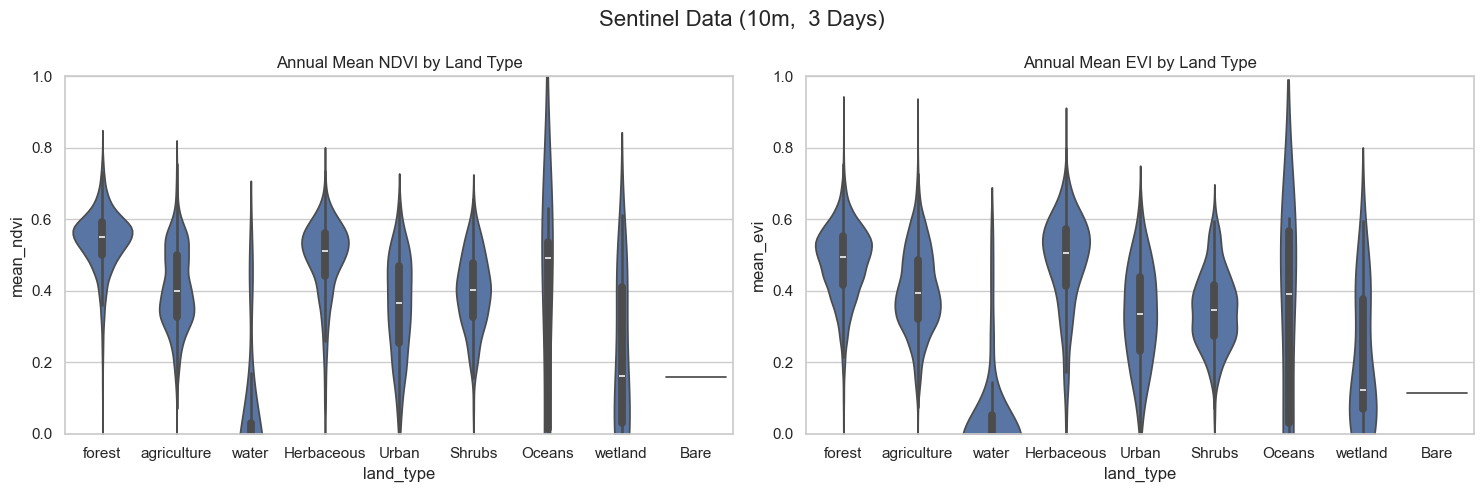

In [ ]:
plot_violin(data_sentinel_mean, "Sentinel Data (10m,  3 Days)")

### Landsat

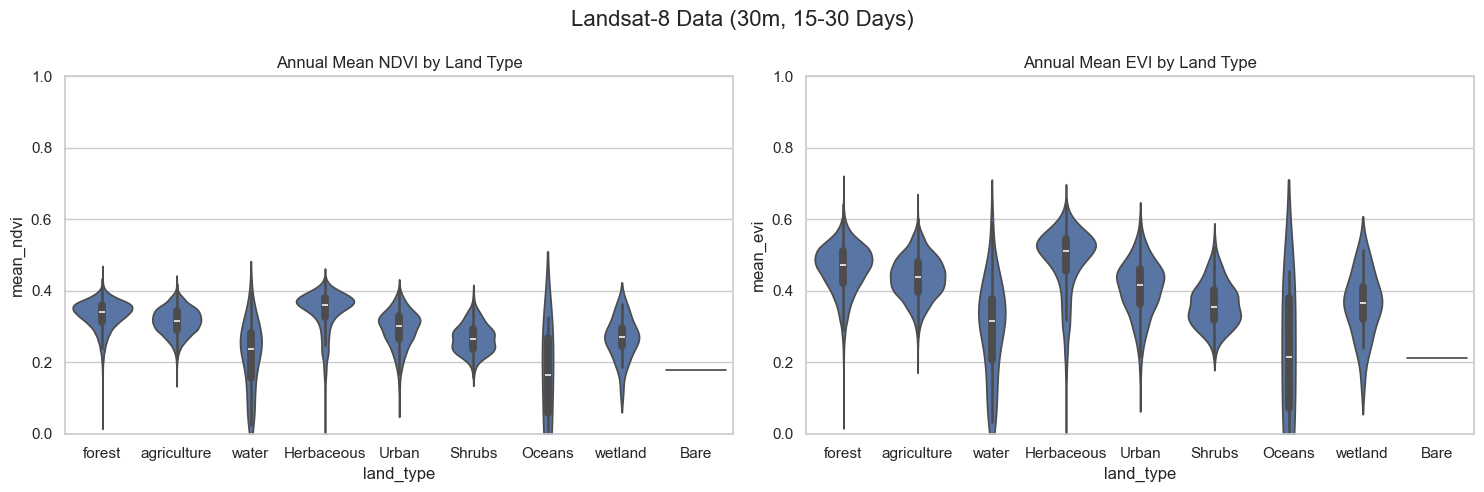

In [ ]:
plot_violin(data_landsat_mean, "Landsat-8 Data (30m, 15-30 Days)")

In [ ]:
modis_suf = data_modis_mean.set_index(["SiteID", "first_year"]).add_suffix("_modis")
landsat_suf = data_landsat_mean.set_index(["SiteID", "first_year"]).add_suffix(
    "_landsat"
)
sentinel_suf = data_sentinel_mean.set_index(["SiteID", "first_year"]).add_suffix(
    "_sentinel"
)

# print(modis_suf.head(10))

m1 = pd.merge(modis_suf, landsat_suf, left_index=True, right_index=True)
m2 = pd.merge(m1, sentinel_suf, left_index=True, right_index=True)

evi = m2.filter(like="evi")
evi.columns = evi.columns.str.replace("mean_evi_", "")

ndvi = m2.filter(like="ndvi")
ndvi.columns = ndvi.columns.str.replace("mean_ndvi_", "")

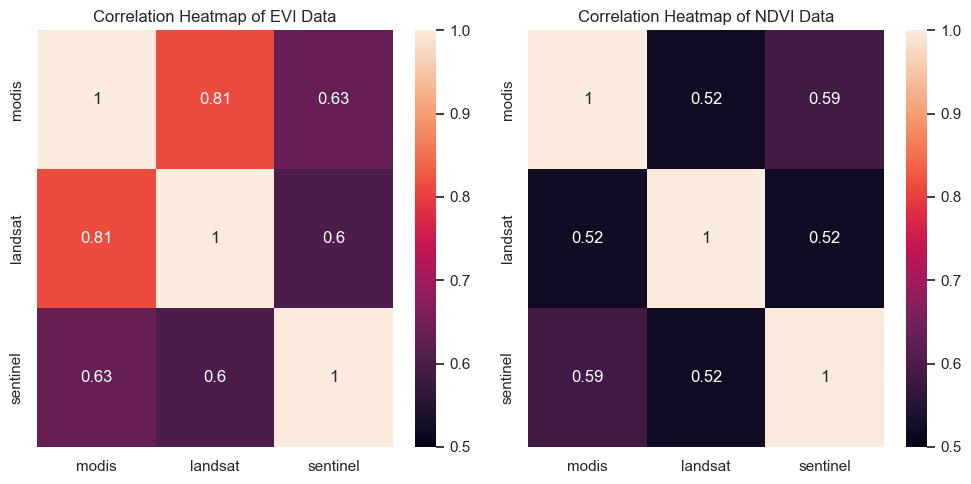

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# Plot the correlation heatmap of EVI data
axs[0].set_title("Correlation Heatmap of EVI Data")
sns.heatmap(evi.corr(), annot=True, ax=axs[0], vmin=0.5, vmax=1)

# Plot the correlation heatmap of NDVI data
axs[1].set_title("Correlation Heatmap of NDVI Data")
sns.heatmap(ndvi.corr(), annot=True, ax=axs[1], vmin=0.5, vmax=1)

plt.tight_layout()